In [40]:
from skimage import io
import scipy.ndimage as ndi
import random
from tqdm import tqdm
import numpy as np
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, jaccard_score
import matplotlib.pyplot as plt
from scipy.spatial.distance import dice

from pathlib import Path
import os

In [41]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_curve

In [42]:
data_dir = "/users/shrey2/Documents/NDD/brainlit/docs/notebooks/utils/data"
print(f"Downloading segments to {data_dir}")
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

im_dir = Path(os.path.join(data_dir, "sample-tif-location"))
if not os.path.exists(im_dir):
    os.makedirs(im_dir)

swc_dir = os.path.join(data_dir, "sample-swc-location")
if not os.path.exists(swc_dir):
    os.makedirs(swc_dir)

mask_dir = Path(os.path.join(data_dir, "mask-location"))

swc_base_path = Path(swc_dir) / "Manual-GT"

gfp_files = list(im_dir.glob("**/*-gfp.tif"))

ms = ""

In [43]:
X_torch = []
y_torch = []

for i, im_path in enumerate(tqdm(gfp_files)):

    f = im_path.parts[-1][:-8].split("_")
    image = f[0]
    num = int(f[1])

    if (image == "test" and num in [9,10,24]) or (image == "validation" and num in [11]):
        continue

    #getting image
    im = io.imread(im_path, plugin="tifffile")
    im = (im - np.amin(im)) / (np.amax(im) - np.amin(im))
    im = np.swapaxes(im,0,2)
    im_padded = np.pad(im, ((4,4), (4,4), (3,3)) )
    
    #getting ground truth mask
    file_name = str(im_path)[str(im_path).find("\\", 80) + 1 : (str(im_path).find("sample"))] + "/mask-location/"
    file_num = file_name[file_name.find("_")+1:]
    if file_name[0] == 'v':
        file_num = str(int(file_num)+25)
    mask_path = Path(file_name + f[0] + "_" + f[1] + "_mask.npy")
    mask = np.load(mask_path)
    
    X_torch.append(im)
    y_torch.append(mask)

100%|███████████████████████████████████████████| 50/50 [00:10<00:00,  4.61it/s]


In [44]:
X_torch_train = X_torch[0:30]
y_torch_train = y_torch[0:30]
x_torch_test = X_torch[31:45]
y_torch_test = y_torch[31:45]

training_data = torch.tensor([X_torch_train, y_torch_train]).float()
test_data = torch.tensor([x_torch_test, y_torch_test]).float()

batch_size = 2

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

In [45]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Feature batch shape: torch.Size([30, 330, 330, 100])
Labels batch shape: torch.Size([30, 330, 330, 100])
Using cpu device


### Manual Baseline Pytorch Model

In [47]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        #self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            #nn.Linear(10890000, 46),
            #nn.ReLU(),
            #nn.Linear(46, 46),
            #nn.ReLU(),
            #nn.Linear(46, 10),
            nn.Conv2d(330, 660, 1, 1),
            nn.ReLU(),
            nn.Conv2d(660, 990, 1, 1),
            nn.ReLU(),
            nn.Conv2d(990, 10, 1, 1),
            nn.ReLU(),
            nn.Conv2d(10, 330, 1, 1),
            
            nn.ConvTranspose2d(330, 330, 1, 1),

            #nn.ConvTranspose2D(330, 330, 1, 1)
            #nn.Conv2d(330, 330, 1, 1),
            #nn.Conv2d(330, 330, 1, 1),

            #nn.Conv2d(660, 660, 1, 1),
            #nn.Conv2d(660, 330, 1, 1),

            #nn.MaxPool2d(330),
            #nn.Linear(1000, 330),

            #nn.Conv2d(100, 100, 1, 1),
            #nn.Conv2d(100, 330, 1, 1),
            #nn.Linear(330,330),
        )

    def forward(self, x):
        #x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        #logits = self.linear(x)
        #logits = nn.Softmax(dim=1)(logits)
        self.Sigmoid = nn.Sigmoid()
        logits = self.Sigmoid(logits)
        #logits = torch.round(x).clone()
        return logits
    
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Conv2d(330, 660, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(660, 990, kernel_size=(1, 1), stride=(1, 1))
    (3): ReLU()
    (4): Conv2d(990, 10, kernel_size=(1, 1), stride=(1, 1))
    (5): ReLU()
    (6): Conv2d(10, 330, kernel_size=(1, 1), stride=(1, 1))
    (7): ConvTranspose2d(330, 330, kernel_size=(1, 1), stride=(1, 1))
  )
)


In [48]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    #size = 330*330*100*14
    y_true = []
    y_pred = []
    for batch, (X, y) in enumerate(dataloader):
    #for (X, y) in enumerate(dataloader):
        #print(X)
        # Compute prediction and loss
        #print(batch)
        #print(X.shape)
        #X = X.unsqueeze(3)
        #print(X.shape)
        optimizer.zero_grad()
        pred = model(X)
        pred = torch.squeeze(pred, 3).clone()
        #pred = torch.squeeze(pred, 3)
        #print(pred.shape)
        #print(y.shape)

        loss = loss_fn(pred, y)

        # Backpropagation
        #optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        #getting accuracy
        #pred_r = np.round(pred.detach().numpy())
        #target = y.float()
        #y_true.extend(target.tolist()) 
        #y_pred.extend(pred_r.reshape(-1).tolist())
        #print(len(y_true))
        #print(len(y_pred))
                
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        
    #print("Accuracy on training set is", accuracy_score(y_true,y_pred))



def test_loop(dataloader, model, loss_fn):
    #size = len(dataloader.dataset)
    size = 330*330*100*14
    print("Size: ", size)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    
    y_true = []
    y_pred = []


    with torch.no_grad():
        for X, y in dataloader:
            #X = X.unsqueeze(3)
            pred = model(X)
            pred = torch.squeeze(pred, 3)
            test_loss += loss_fn(pred, y).item()
            #print(pred.shape)
            #print(y.shape)
            correct += (pred == y).type(torch.float).sum().item()
            #correct += y.sum()
            
            #PREDICTIONS
            #pred_r = np.round(pred)
            #target = y.float()
            #y_true.extend(target.tolist()) 
            #y_pred.extend(pred_r.reshape(-1).tolist())
    
    #print("Accuracy on test set is" , accuracy_score(y_true,y_pred))
    
    test_loss /= num_batches
    correct /= size
    print("Correct: ", correct)
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    
    return pred, test_loss

In [49]:
#pred, pred_list, loss_list = test_loop(test_dataloader, model, loss_fn)

In [50]:
loss_fn = nn.BCELoss()
learning_rate = 0.8
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
epochs = 3

pred_list = []
loss_list = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    pred, loss = test_loop(test_dataloader, model, loss_fn)
    pred_list.append(pred)
    loss_list.append(loss)
print("Done!")

Epoch 1
-------------------------------
loss: 0.696159  [    0/    2]
Size:  152460000
Correct:  0.0
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.688285 

Epoch 2
-------------------------------
loss: 0.688274  [    0/    2]
Size:  152460000
Correct:  0.0
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.680542 

Epoch 3
-------------------------------
loss: 0.680528  [    0/    2]
Size:  152460000
Correct:  0.0
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.672908 

Done!


In [51]:
preds_0 = pred.numpy()[0].round().astype(int)

print("Accuracy: ", accuracy_score(y_torch_test[0].astype(int).flatten(), preds_0.flatten()))
print("Precision: ", precision_score(y_torch_test[0].astype(int).flatten(), preds_0.flatten()))
print("Recall: ", recall_score(y_torch_test[0].astype(int).flatten(), preds_0.flatten()))
print("Nonzeros: ", np.count_nonzero(preds_0.flatten()))
print("Nonzeros percent: ", np.count_nonzero(preds_0.flatten()) / len(y_torch_test[0].astype(int).flatten()) * 100)

Accuracy:  0.6448780532598715
Precision:  0.0013692552851777792
Recall:  0.31793854110289255
Nonzeros:  3861223
Nonzeros percent:  35.456593204775025


In [57]:
pred_list[0].shape

torch.Size([14, 330, 330, 100])

330
330
330


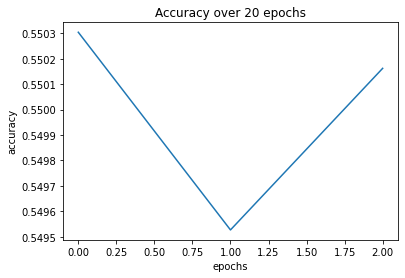

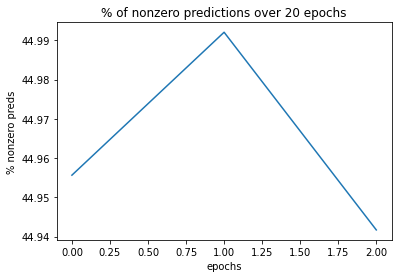

In [75]:
import matplotlib.pyplot as plt

acc_list = []
nonzero_list = []
for i in range(len(loss_list)):
    pred = pred_list[0][i].numpy().round().astype(int)
    print(len(pred))
    acc = accuracy_score(y_torch_test[i].astype(int).flatten(), pred.flatten())
    acc_list.append(acc)
    
    nonzero = np.count_nonzero(pred.flatten()) / len(y_torch_test[i].astype(int).flatten()) * 100
    nonzero_list.append(nonzero)

plt.figure()
plt.title("Accuracy over 3 epochs")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.plot(acc_list)

plt.figure()
plt.title("% of nonzero predictions over 2 epochs")
plt.xlabel("epochs")
plt.ylabel("% nonzero preds")
plt.plot(nonzero_list)

[0.6882847547531128, 0.6805418133735657, 0.6729077696800232]

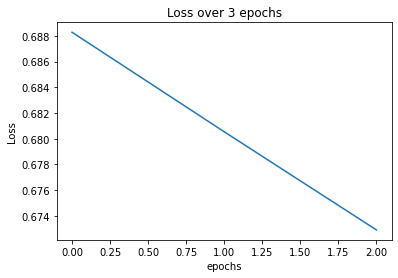

In [64]:
plt.figure()
plt.title("Loss over 3 epochs")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.plot(loss_list)

loss_list

In [73]:
pred_list[0][0].numpy().round().astype(int).shape

(330, 330, 100)

In [74]:
import napari
with napari.gui_qt():
    viewer = napari.Viewer(ndisplay=3)
    viewer.add_image((x_torch_test[0]))
    viewer.add_labels((y_torch_test[0]).astype(int))
    viewer.add_labels(pred_list[0][0].numpy().round().astype(int))

/Users/shrey2/opt/anaconda3/envs/nd/lib/python3.9/site-packages/napari/_qt/qt_event_loop.py:256: FutureWarning: 
The 'gui_qt()' context manager is deprecated.
If you are running napari from a script, please use 'napari.run()' as follows:

    import napari

    viewer = napari.Viewer()  # no prior setup needed
    # other code using the viewer...
    napari.run()

In IPython or Jupyter, 'napari.run()' is not necessary. napari will automatically
start an interactive event loop for you: 

    import napari
    viewer = napari.Viewer()  # that's it!

  warn(


In [ ]:
precision, recall, thresholds = precision_recall_curve(y_torch_test[0].astype(int).flatten(), pred.numpy()[0].astype(int).flatten())

plt.plot(precision, recall)

### AlexNet

In [ ]:
import torch
model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
model.eval()

In [ ]:
#model.features[0] = nn.Conv2d(330, 3, 1, 1),
#model.Conv2D = nn.Conv2D(330, 330, 1, 1)
model.features[0] = nn.Conv2d(330, 64, 1, 1)
#model.features[12] = nn.Conv2d(256, 9216, 1, 1)

#model.fc = nn.Linear(4096, 330) 
#model.classifier[1] = nn.Conv2d(9216, 4096, 1, 1)
#model.classifier[4] = nn.Conv2d(4096, 4096, 1, 1)
model.classifier[6] = nn.Conv2d(4096, 330, 1, 1)

#model.classifier[6] = nn.ConvTranspose2d(4096, 330, 1, 1)
model.eval()

In [ ]:
correct = 0
with torch.no_grad():
    for X, y in test_dataloader:
        pred = model(X)
        #pred = torch.squeeze(pred, 3)
        #test_loss += loss_fn(pred, y).item()
            
        #correct += (pred == y).type(torch.float).sum().item()
            

#print("Correct: ", correct)
#print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%Avg loss: {test_loss:>8f} \n")
    


In [ ]:
with torch.no_grad():
    output = model(test_dataloader)
print(output[0])

### uNet

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=1, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )
        

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=1, stride=1)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)
    

In [ ]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 330)
        self.down1 = Down(330, 330)
        self.down2 = Down(330, 330)
        self.down3 = Down(330, 330)
        factor = 2 if bilinear else 1
        self.down4 = Down(330, 330 // factor)
        self.up1 = Up(330, 330 // factor, bilinear)
        self.up2 = Up(330, 330 // factor, bilinear)
        self.up3 = Up(330, 330 // factor, bilinear)
        self.up4 = Up(330, 330, bilinear)
        self.outc = OutConv(330, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits
    
UNetModel = UNet(330, 330).to(device)


In [ ]:
#for X, y in test_dataloader:
#    with torch.no_grad():
#        output = UNetModel(X)
#    # Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
#    print(output[0].shape)

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    #size = 330*330*100*14
    y_true = []
    y_pred = []
    for batch, (X, y) in enumerate(dataloader):

        optimizer.zero_grad()
        pred = model(X)
        pred = torch.squeeze(pred, 3).clone()
        #pred = torch.squeeze(pred, 3)
        #print(pred.shape)
        #print(y.shape)

        loss = loss_fn(pred, y)

        # Backpropagation
        #optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        #getting accuracy
        #pred_r = np.round(pred.detach().numpy())
        #target = y.float()
        #y_true.extend(target.tolist()) 
        #y_pred.extend(pred_r.reshape(-1).tolist())
        #print(len(y_true))
        #print(len(y_pred))
                
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        
    #print("Accuracy on training set is", accuracy_score(y_true,y_pred))


def test_loop(dataloader, model, loss_fn):
    #size = len(dataloader.dataset)
    size = 330*330*100*14
    print("Size: ", size)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    
    y_true = []
    y_pred = []

    with torch.no_grad():
        for X, y in dataloader:
            #X = X.unsqueeze(3)
            pred = model(X)
            #pred = torch.squeeze(pred, 3)
            test_loss += loss_fn(pred, y).item()
            #print(pred.shape)
            #print(y.shape)
            correct += (pred == y).type(torch.float).sum().item()
            #correct += y.sum()
            
            #PREDICTIONS
            #pred_r = np.round(pred)
            #target = y.float()
            #y_true.extend(target.tolist()) 
            #y_pred.extend(pred_r.reshape(-1).tolist())
    
    #print("Accuracy on test set is" , accuracy_score(y_true,y_pred))
    
    test_loss /= num_batches
    correct /= size
    print("Correct: ", correct)
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    
    return pred

In [ ]:
loss_fn = nn.BCELoss()
learning_rate = 0.8
optimizer = torch.optim.SGD(UNetModel.parameters(), lr=learning_rate)
epochs = 5

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, UNetModel, loss_fn, optimizer)
    pred = test_loop(test_dataloader, UNetModel, loss_fn)
print("Done!")

In [ ]:
output_norm = output.numpy()
output_norm = abs(output_norm).astype(int)
print("nonzero num: ", np.count_nonzero(output_norm))
print(output_norm[0].shape)

In [ ]:
preds_0 = output_norm[0]

print("Accuracy: ", accuracy_score(y_torch_test[0].astype(int).flatten(), preds_0.flatten()))
print("Precision: ", precision_score(y_torch_test[0].astype(int).flatten(), preds_0.flatten()))
print("Recall: ", recall_score(y_torch_test[0].astype(int).flatten(), preds_0.flatten()))
print("Nonzeros: ", np.count_nonzero(preds_0.flatten()))
print("Nonzeros percent: ", np.count_nonzero(preds_0.flatten()) / len(y_torch_test[0].astype(int).flatten()) * 100)